# Sports vs Politics Text Classification - Exploratory Data Analysis

This notebook contains the data analysis and visualization components of the project.
For the classification models, see `text_classifier.py`.

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from wordcloud import WordCloud, STOPWORDS

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## 1. Data Loading

In [2]:
import kagglehub
import os

# Download dataset
path = kagglehub.dataset_download("sunilthite/text-document-classification-dataset")

print("Path to dataset files:", path)
files = os.listdir(path)
print("Files in dataset:", files)

# Load the CSV file
csv_path = os.path.join(path, 'df_file.csv')
print(f"Using CSV at: {csv_path}")

Path to dataset files: /home/akash/.cache/kagglehub/datasets/sunilthite/text-document-classification-dataset/versions/1
Files in dataset: ['df_file.csv']
Using CSV at: /home/akash/.cache/kagglehub/datasets/sunilthite/text-document-classification-dataset/versions/1/df_file.csv


In [3]:
# Load Dataset
df = pd.read_csv(csv_path)
display(df.head())
print(f"\nDataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

,Text,Label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0



Dataset shape: (2225, 2)
Columns: ['Text', 'Label']


## 2. Data Preprocessing

In [4]:
# Keep only Politics and Sports
label_map = {0: "Politics", 1: "Sports"}

df = df[df["Label"].isin([0, 1])]
df["Label"] = df["Label"].map(label_map)

print("Class distribution:")
print(df["Label"].value_counts())
print(f"\nTotal documents: {len(df)}")

Class distribution:
Label
Sports      511
Politics    417
Name: count, dtype: int64

Total documents: 928


In [5]:
# Basic cleaning
df.dropna(subset=["Text"], inplace=True)
df["Text"] = df["Text"].astype(str)
df = df[df["Text"].str.strip() != ""]

print(f"After cleaning: {len(df)} documents")

After cleaning: 928 documents


In [6]:
# Text preprocessing function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\\s]", " ", text)
    text = re.sub(r"\\s+", " ", text).strip()
    return text

df["clean_text"] = df["Text"].apply(clean_text)
print("Text preprocessing completed!")

# Show example
print("\nExample:")
print(f"Original: {df.iloc[0]['Text'][:100]}...")
print(f"Cleaned: {df.iloc[0]['clean_text'][:100]}...")

Text preprocessing completed!

Example:
Original: Budget to set scene for election
 
 Gordon Brown will seek to put the economy at the centre of Labou...
Cleaned: budget to set scene for election    gordon brown will seek to put the economy at the centre of labou...


## 3. Feature Engineering

In [7]:
# Feature Engineering
df["word_count"] = df["clean_text"].apply(lambda x: len(x.split()))
df["char_count"] = df["clean_text"].apply(len)

print("Feature statistics:")
print(df[["word_count", "char_count"]].describe())

Feature statistics:
        word_count    char_count
count   928.000000    928.000000
mean    395.226293   2258.800647
std     257.029006   1456.612184
min      91.000000    505.000000
25%     250.750000   1405.000000
50%     357.500000   2020.000000
75%     498.000000   2874.000000
max    4491.000000  25594.000000


## 4. Exploratory Data Analysis

### 4.1 Class Distribution

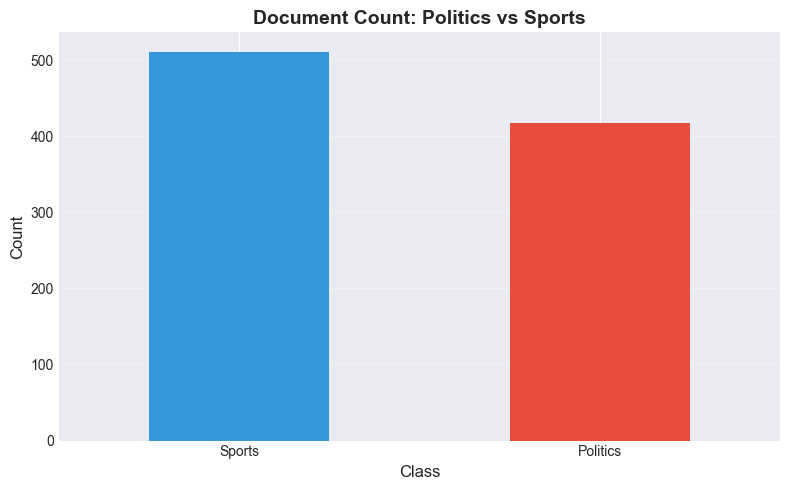

In [8]:
# Class distribution
plt.figure(figsize=(8, 5))
df["Label"].value_counts().plot(kind="bar", color=['#3498db', '#e74c3c'])
plt.title("Document Count: Politics vs Sports", fontsize=14, fontweight='bold')
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 4.2 Text Length Analysis

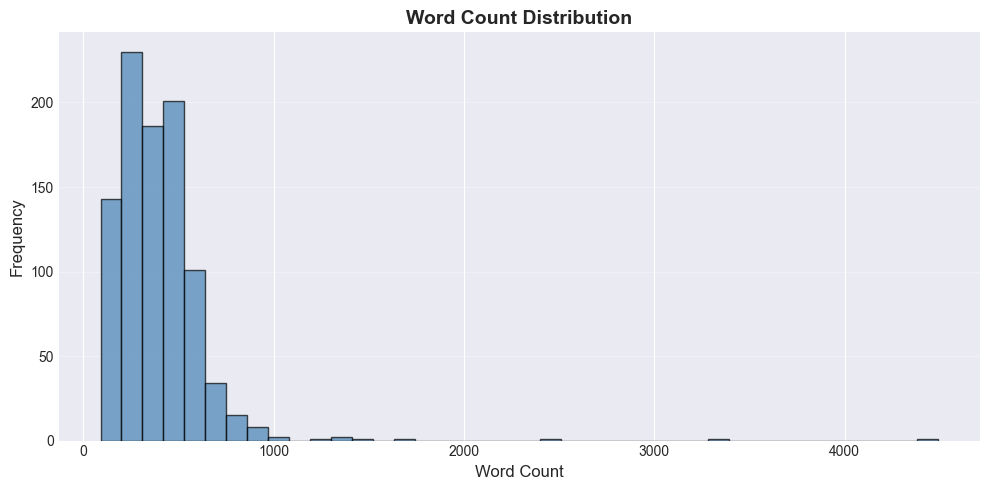

In [9]:
# Word count distribution
plt.figure(figsize=(10, 5))
plt.hist(df["word_count"], bins=40, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel("Word Count", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Word Count Distribution", fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipykernel_8918/4132659085.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Label", y="word_count", data=df, palette=['#3498db', '#e74c3c'])


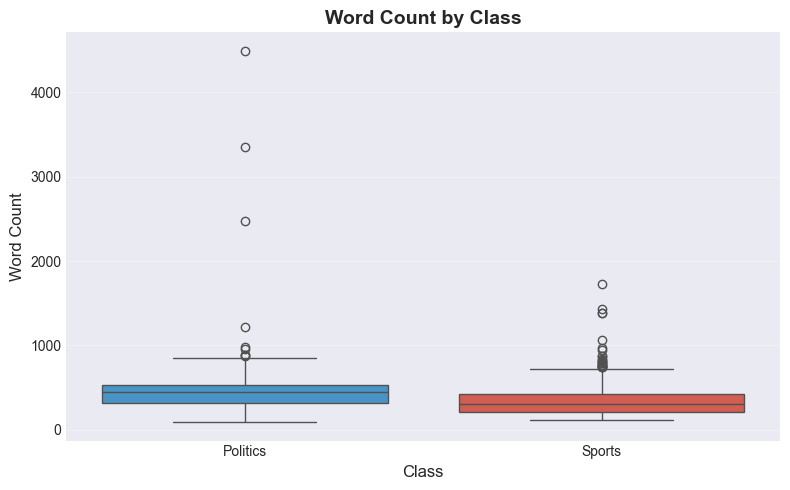

In [10]:
# Word count by class
plt.figure(figsize=(8, 5))
sns.boxplot(x="Label", y="word_count", data=df, palette=['#3498db', '#e74c3c'])
plt.title("Word Count by Class", fontsize=14, fontweight='bold')
plt.xlabel("Class", fontsize=12)
plt.ylabel("Word Count", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 4.3 N-gram Analysis

In [11]:
# Top unigrams function
def top_ngrams(texts, ngram_range=(1,1), top_n=20):
    vec = CountVectorizer(
        stop_words="english",
        ngram_range=ngram_range
    )
    X = vec.fit_transform(texts)
    freqs = X.sum(axis=0)

    words = [
        (w, freqs[0, i])
        for w, i in vec.vocabulary_.items()
    ]

    return sorted(words, key=lambda x: x[1], reverse=True)[:top_n]

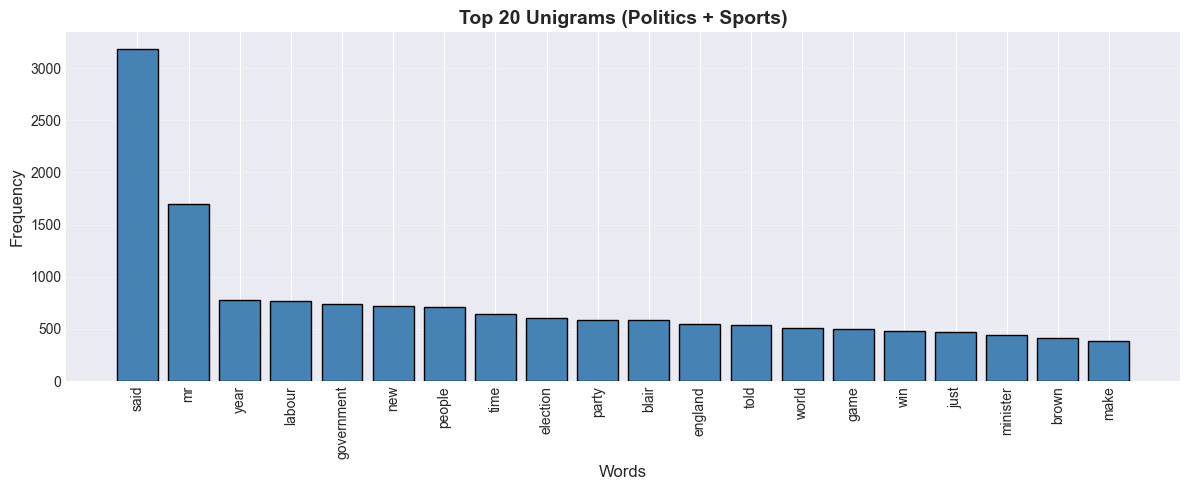

In [12]:
# Top unigrams visualization
uni = top_ngrams(df["clean_text"], (1,1))
words, counts = zip(*uni)

plt.figure(figsize=(12, 5))
plt.bar(words, counts, color='steelblue', edgecolor='black')
plt.xticks(rotation=90)
plt.xlabel("Words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Top 20 Unigrams (Politics + Sports)", fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 4.4 Word Cloud Visualizations

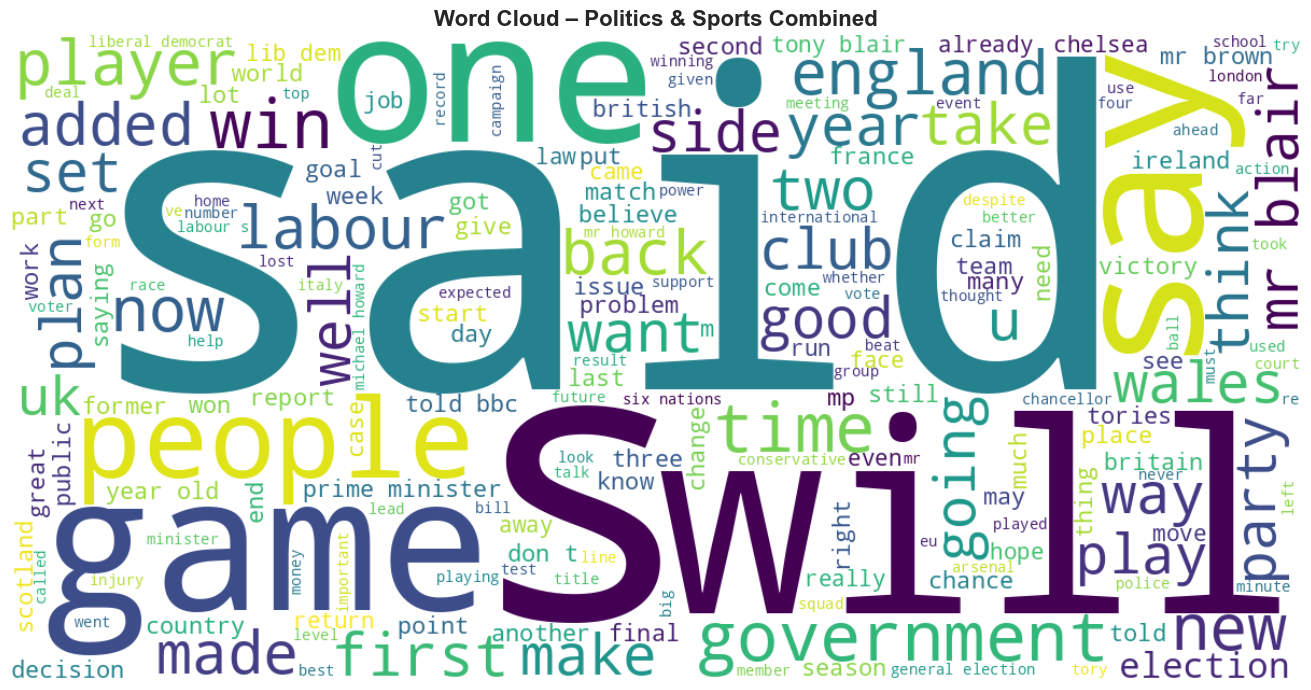

In [13]:
# Overall word cloud
text_all = " ".join(df["clean_text"].values)

wc_all = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    stopwords=STOPWORDS,
    max_words=200,
    colormap='viridis'
)

plt.figure(figsize=(15, 7))
plt.imshow(wc_all.generate(text_all), interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud – Politics & Sports Combined", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

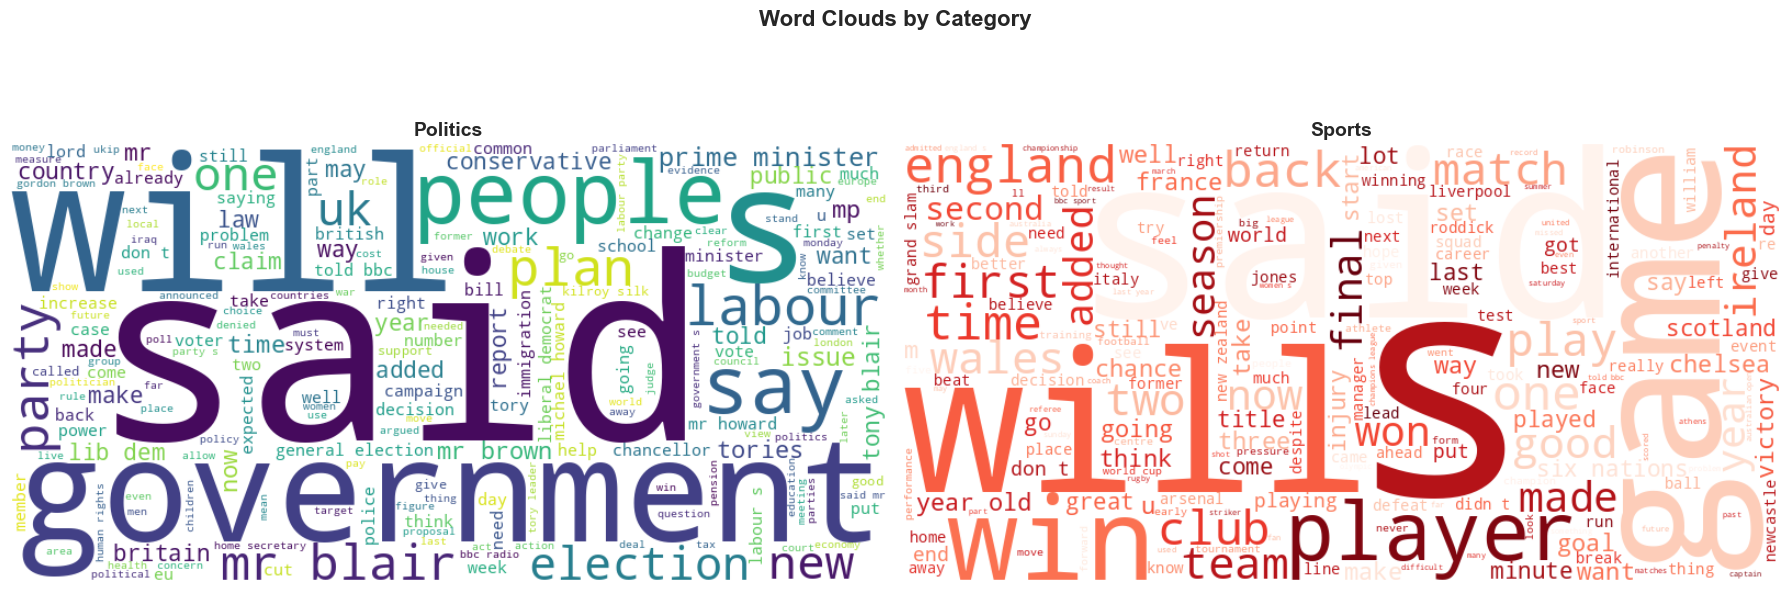

In [14]:
# Class-specific word clouds
politics_text = " ".join(
    df[df["Label"] == "Politics"]["clean_text"].values
)

sports_text = " ".join(
    df[df["Label"] == "Sports"]["clean_text"].values
)

wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=STOPWORDS,
    max_words=200
)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Politics
axes[0].imshow(wc.generate(politics_text), interpolation="bilinear")
axes[0].set_title("Politics", fontsize=14, fontweight='bold')
axes[0].axis("off")

# Sports
wc_sports = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=STOPWORDS,
    max_words=200,
    colormap='Reds'
)
axes[1].imshow(wc_sports.generate(sports_text), interpolation="bilinear")
axes[1].set_title("Sports", fontsize=14, fontweight='bold')
axes[1].axis("off")

plt.suptitle("Word Clouds by Category", fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## 5. Summary

This notebook contains all the exploratory data analysis and visualizations.

**For classification models and predictions, run:**
```bash
python text_classifier.py
```

The classifier script will:
- Train Naive Bayes, Random Forest, and SVM models
- Generate performance metrics
- Create confusion matrices and comparison plots